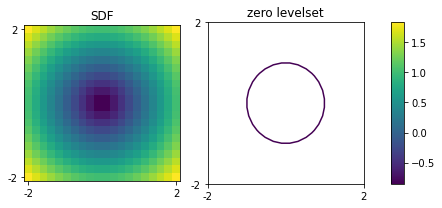

In [1]:
import jax
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline
import functools as ft
import optax
from sdf_jax import plot2d, discretize2d


def sdf_sphere(x):
    return jnp.linalg.norm(x) - 1

plot2d(sdf_sphere, ngrid=20)

In [22]:
import treex as tx
from typing import Sequence, Callable

class SimpleNeuralSDF(tx.Module):
    def __init__(self, dims: Sequence[int], act: Callable):
        self.dims = dims
        self.act = act
    @tx.compact
    def __call__(self, x):
        assert x.ndim == 1
        for dim in self.dims:
            x = tx.Linear(dim)(x)
            x = self.act(x)
        y = tx.Linear(1)(x)
        return y[0]
    
@ft.partial(jax.value_and_grad, has_aux=True)
def loss_fn(params, model, x, y):
    model = model.merge(params)
    preds = jax.vmap(model)(x)
    loss = 0.5 * jnp.mean((preds - y) ** 2)
    return loss, model

@jax.jit
def train_step(model, x, y, optimizer):
    params = model.filter(tx.Parameter)
    (loss, model), grads = loss_fn(params, model, x, y)

    new_params = optimizer.update(grads, params)
    model = model.merge(new_params)

    return loss, model, optimizer

def print_callback(step, loss, model, optimizer):
    print(f"[{step}] loss: {loss:.4f}")

def fit(
    sdf=sdf_sphere,
    ngrid=20,
    # module
    dims=[50,50],
    act=jax.nn.relu,
    # optimizer
    seed=42,
    lr=5e-3,
    steps=100,
    # utils
    cb=print_callback,
    cb_every=10,
):
    xs, ys = discretize2d(sdf, xy_lims=(-2, 2), ngrid=ngrid)
    xs = xs.reshape(-1, 2)
    ys = ys.reshape(-1)
    model = SimpleNeuralSDF(dims=dims, act=act).init(seed, xs[0])
    optimizer = tx.Optimizer(optax.adam(lr))
    optimizer = optimizer.init(model.filter(tx.Parameter))
    for step in range(steps):
        loss, model, optimizer = train_step(model, xs, ys, optimizer)
        if step % cb_every == 0:
            cb(step, loss, model, optimizer)
    return loss, model

In [23]:
loss, model = fit()

[0] loss: 0.3805
[10] loss: 0.0901
[20] loss: 0.0582
[30] loss: 0.0400
[40] loss: 0.0297
[50] loss: 0.0209
[60] loss: 0.0127
[70] loss: 0.0050
[80] loss: 0.0010
[90] loss: 0.0006


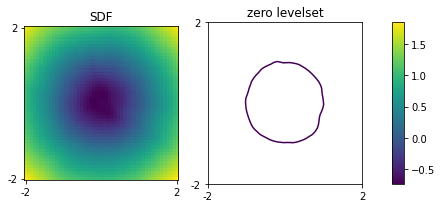

In [24]:
plot2d(model, ngrid=50)

[0] loss: 0.3811
[10] loss: 0.1189
[20] loss: 0.0792
[30] loss: 0.0529
[40] loss: 0.0268
[50] loss: 0.0101
[60] loss: 0.0048
[70] loss: 0.0049
[80] loss: 0.0047
[90] loss: 0.0043


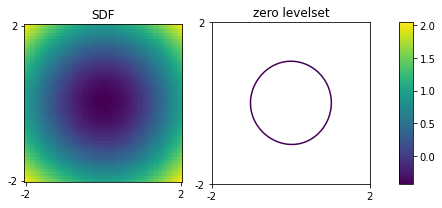

In [25]:
loss, model = fit(act=jax.nn.softplus)
plot2d(model, ngrid=50)

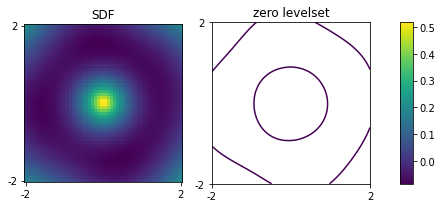

In [26]:
plot2d(lambda x: model(x) - sdf_sphere(x), ngrid=50)